In [17]:
# ==================================
# 1. Convert XML (VOC) to CSV (train + test)
# ==================================
import os
import xml.etree.ElementTree as ET
import pandas as pd

def parse_voc_xml_to_records(xml_dir):
    records = []
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith('.xml'):
            continue
        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()
        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text) if size.find('width') is not None else 640
        height = int(size.find('height').text) if size.find('height') is not None else 640
        for obj in root.findall('object'):
            cls = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            records.append([filename, width, height, cls, xmin, ymin, xmax, ymax])
    return records
train_xml_path = "archive/train_zip/train"
test_xml_path = "archive/test_zip/test"
train_records = parse_voc_xml_to_records(train_xml_path)
test_records = parse_voc_xml_to_records(test_xml_path)
train_df = pd.DataFrame(train_records, columns=["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"])
test_df = pd.DataFrame(test_records, columns=["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"])
train_df.to_csv("train_annotations.csv", index=False)
test_df.to_csv("test_annotations.csv", index=False)

In [18]:
# ==================================
# 2. Imports
# ==================================
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
# ==================================
# 3. Dataset Definition
# ==================================
class FruitDataset(Dataset):
    def __init__(self, annotations, img_dir, transforms=None):
        self.annotations = pd.read_csv(annotations)
        self.img_dir = img_dir
        self.imgs = self.annotations['filename'].unique()
        self.transforms = transforms
        self.class_dict = {c: i+1 for i, c in enumerate(self.annotations['class'].unique())}
        self.classes = list(self.class_dict.keys())
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        records = self.annotations[self.annotations['filename'] == img_name]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = records['class'].apply(lambda x: self.class_dict[x]).values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
        if self.transforms:
            img = self.transforms(img)
        return img, target

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
# ==================================
# 4. Load Train Data
# ==================================
train_dataset = FruitDataset(
    annotations='train_annotations.csv',
    img_dir='archive/train_zip/train',
    transforms=T.Compose([T.ToTensor()])
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [22]:
# ==================================
# 5. Load Faster R-CNN Model
# ==================================
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
num_classes = len(train_dataset.class_dict) + 1
model = get_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\Fairuz\torch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fairuz\torch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

In [24]:
# ==================================
# 6. Train
# ==================================
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.4157
Epoch [2/10], Loss: 0.2129
Epoch [3/10], Loss: 0.1530
Epoch [4/10], Loss: 0.1495
Epoch [5/10], Loss: 0.1238
Epoch [6/10], Loss: 0.1059
Epoch [7/10], Loss: 0.0978
Epoch [8/10], Loss: 0.0926
Epoch [9/10], Loss: 0.0923
Epoch [10/10], Loss: 0.0824


In [25]:
# ==================================
# 7. Save Model
# ==================================
torch.save(model.state_dict(), "fruit_detector.pth")

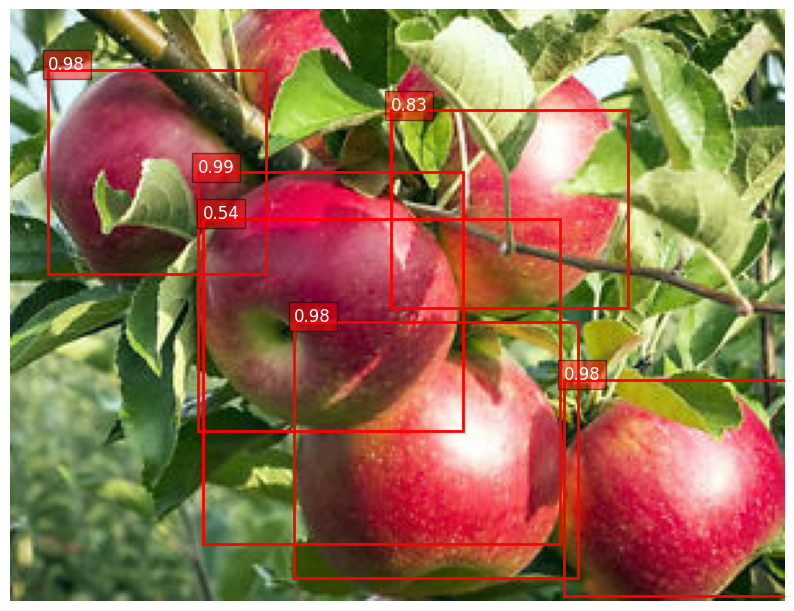

In [26]:
# ==================================
# 8. Test Inference & Visualization
# ==================================
model.eval()
test_dataset = FruitDataset(
    annotations='test_annotations.csv',
    img_dir='archive/test_zip/test',
    transforms=T.Compose([T.ToTensor()])
)
img, _ = test_dataset[0]
with torch.no_grad():
    prediction = model([img.to(device)])
img = img.permute(1, 2, 0).numpy()
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
for box, score in zip(boxes, scores):
    if score > 0.5:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"{score:.2f}", fontsize=12, color='white',
                bbox=dict(facecolor='red', alpha=0.5))
plt.axis('off')
plt.show()

In [27]:
# ==================================
# 9. Model Evaluation
# ==================================

from torchvision.ops import box_iou

def evaluate_model(model, dataset, device, iou_threshold=0.5):
    model.eval()
    total_tp, total_fp, total_fn = 0, 0, 0

    with torch.no_grad():
        for img, target in dataset:
            img = img.to(device)
            target_boxes = target["boxes"].to(device)

            output = model([img])[0]
            pred_boxes = output["boxes"][output["scores"] > 0.5]

            if len(pred_boxes) == 0:
                total_fn += len(target_boxes)
                continue

            ious = box_iou(pred_boxes, target_boxes)
            matches = (ious > iou_threshold).sum().item()

            total_tp += matches
            total_fp += len(pred_boxes) - matches
            total_fn += len(target_boxes) - matches

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")


In [28]:
evaluate_model(model, test_dataset, device)

Precision: 0.908
Recall:    1.009
F1 Score:  0.955


In [29]:
# ==================================
# 9. Model Summary
# ==================================

def model_summary(model):
    num_params = sum(p.numel() for p in model.parameters())
    num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    layers = len(list(model.modules()))
    print(f"Model Summary: {layers} layers, {num_params:,} parameters, {num_trainable:,} trainable")

model_summary(model)

Model Summary: 189 layers, 41,309,411 parameters, 41,087,011 trainable


In [30]:
# ==================================
# 10. Per-Class Evaluation Table
# ==================================

import pandas as pd
from collections import defaultdict
from torchvision.ops import box_iou

def evaluate_per_class(model, dataset, device, iou_threshold=0.5):
    class_names = list(dataset.class_dict.keys())
    id_to_class = {v: k for k, v in dataset.class_dict.items()}
    stats = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0, "images": 0, "instances": 0})

    model.eval()
    with torch.no_grad():
        for img, target in dataset:
            img = img.to(device)
            gt_boxes = target["boxes"].to(device)
            gt_labels = target["labels"].to(device)
            output = model([img])[0]
            scores = output["scores"]
            boxes = output["boxes"]
            labels = output["labels"]

            used = set()
            for i, (pb, pl) in enumerate(zip(boxes, labels)):
                if scores[i] < 0.5:
                    continue
                match_found = False
                for j, (gtb, gtl) in enumerate(zip(gt_boxes, gt_labels)):
                    if j in used or pl != gtl:
                        continue
                    if box_iou(pb.unsqueeze(0), gtb.unsqueeze(0)).item() >= iou_threshold:
                        stats[id_to_class[int(pl.item())]]["tp"] += 1
                        used.add(j)
                        match_found = True
                        break
                if not match_found:
                    stats[id_to_class[int(pl.item())]]["fp"] += 1

            for i, gtl in enumerate(gt_labels):
                if i not in used:
                    stats[id_to_class[int(gtl.item())]]["fn"] += 1

            for l in gt_labels:
                stats[id_to_class[int(l.item())]]["instances"] += 1
            for l in set(gt_labels.tolist()):
                stats[id_to_class[int(l)]]["images"] += 1

    table = []
    for cls, val in stats.items():
        tp, fp, fn = val["tp"], val["fp"], val["fn"]
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        table.append({
            "Class": cls,
            "Images": val["images"],
            "Instances": val["instances"],
            "P": round(precision, 3),
            "R": round(recall, 3),
            "F1": round(f1, 3)
        })

    df = pd.DataFrame(table)
    print(df.to_string(index=False))

evaluate_per_class(model, test_dataset, device)

 Class  Images  Instances     P     R    F1
 apple      24         35 0.810 0.971 0.883
banana      22         40 0.762 0.800 0.780
orange      22         42 0.891 0.976 0.932


In [31]:
# ==================================
# 11. Confidence–Score Curves
# ==================================

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision.ops import box_iou

def classwise_confidence_curves(model, dataset, device):
    confs = np.linspace(0.01, 1.0, 50)
    class_names = list(dataset.class_dict.keys())
    id_to_class = {v: k for k, v in dataset.class_dict.items()}
    classwise_prec = defaultdict(list)
    classwise_f1 = defaultdict(list)
    all_prec, all_f1 = [], []

    model.eval()
    with torch.no_grad():
        for thresh in confs:
            stats = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})
            for img, target in dataset:
                img = img.to(device)
                gt_boxes = target["boxes"].to(device)
                gt_labels = target["labels"].to(device)

                output = model([img])[0]
                scores = output["scores"]
                boxes = output["boxes"]
                labels = output["labels"]

                keep = scores > thresh
                pred_boxes = boxes[keep]
                pred_labels = labels[keep]

                used_gt = set()
                for pb, pl in zip(pred_boxes, pred_labels):
                    matched = False
                    for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                        if i in used_gt or pl != gl:
                            continue
                        if box_iou(pb.unsqueeze(0), gb.unsqueeze(0)).item() > 0.5:
                            stats[id_to_class[int(pl.item())]]["tp"] += 1
                            used_gt.add(i)
                            matched = True
                            break
                    if not matched:
                        stats[id_to_class[int(pl.item())]]["fp"] += 1

                for i, gl in enumerate(gt_labels):
                    if i not in used_gt:
                        stats[id_to_class[int(gl.item())]]["fn"] += 1

            all_tp = all_fp = all_fn = 0
            for cls in class_names:
                tp = stats[cls]["tp"]
                fp = stats[cls]["fp"]
                fn = stats[cls]["fn"]
                prec = tp / (tp + fp + 1e-6)
                rec = tp / (tp + fn + 1e-6)
                f1 = 2 * prec * rec / (prec + rec + 1e-6)
                classwise_prec[cls].append(prec)
                classwise_f1[cls].append(f1)
                all_tp += tp
                all_fp += fp
                all_fn += fn

            all_p = all_tp / (all_tp + all_fp + 1e-6)
            all_r = all_tp / (all_tp + all_fn + 1e-6)
            all_f = 2 * all_p * all_r / (all_p + all_r + 1e-6)
            all_prec.append(all_p)
            all_f1.append(all_f)

    return confs, class_names, classwise_prec, classwise_f1, all_prec, all_f1

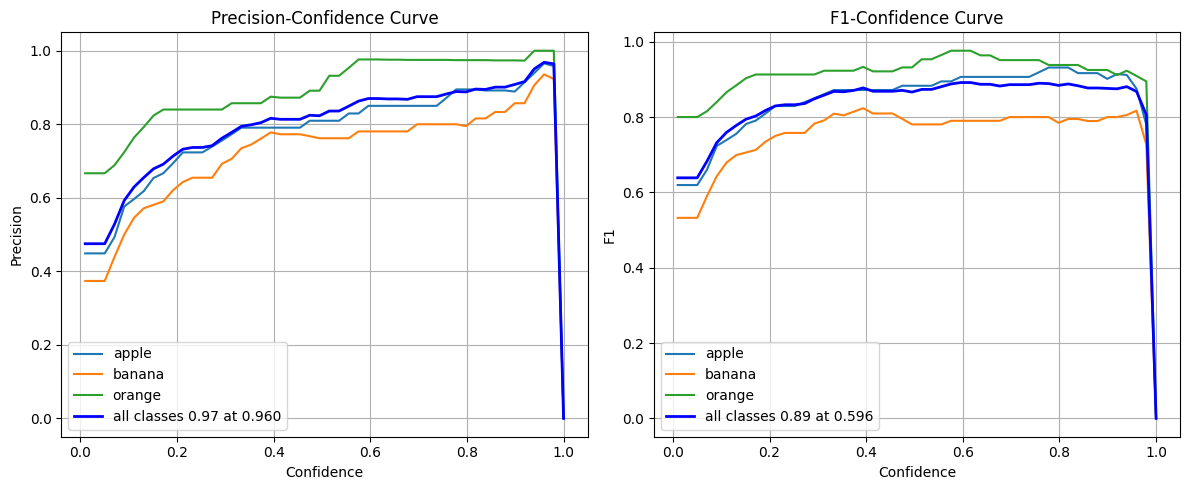

In [32]:
confs, class_names, precs, f1s, all_prec, all_f1 = classwise_confidence_curves(model, test_dataset, device)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for cls in class_names:
    plt.plot(confs, precs[cls], label=cls)
plt.plot(confs, all_prec, label=f"all classes {max(all_prec):.2f} at {confs[np.argmax(all_prec)]:.3f}", linewidth=2, color="blue")
plt.title("Precision-Confidence Curve")
plt.xlabel("Confidence")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for cls in class_names:
    plt.plot(confs, f1s[cls], label=cls)
plt.plot(confs, all_f1, label=f"all classes {max(all_f1):.2f} at {confs[np.argmax(all_f1)]:.3f}", linewidth=2, color="blue")
plt.title("F1-Confidence Curve")
plt.xlabel("Confidence")
plt.ylabel("F1")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("per_class_confidence_curves.png", dpi=300)
plt.show()


In [ ]:
# ==================================
# 12. Detect and Save Multiple Images 
# ==================================

import os
import random
from PIL import ImageDraw, ImageFont
import torchvision.transforms.functional as F

def save_inference_grid(model, dataset, device, save_dir="detections", max_images=20, conf_threshold=0.5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    font = ImageFont.load_default()

    random.seed(42)  # Optional: for consistent selection
    indices = random.sample(range(len(dataset)), min(len(dataset), max_images))

    with torch.no_grad():
        for idx in indices:
            img, target = dataset[idx]
            img_gpu = img.to(device)
            output = model([img_gpu])[0]

            # Convert to PIL image
            img_pil = F.to_pil_image(img.cpu())
            draw = ImageDraw.Draw(img_pil)

            for i, (box, score) in enumerate(zip(output["boxes"], output["scores"])):
                if score < conf_threshold:
                    continue
                x1, y1, x2, y2 = box.cpu().numpy()
                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

                label = output["labels"][i].item()
                class_name = dataset.classes[label - 1]  # adjust for label starting at 1
                draw.text((x1, y1), f"{class_name} {score:.2f}", fill="red", font=font)

            img_pil.save(os.path.join(save_dir, f"result_{idx:02d}.png"))

save_inference_grid(model, test_dataset, device, max_images=20)